# LATAM Airlines

**"Probabilidad de atraso de los vuelos que aterriza o despegan"**

El problema consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL).

Para eso les entregamos un dataset usando datos públicos y reales donde cada fila corresponde a un vuelo que aterrizó o despegó de SCL.

# Instalar las dependencias


In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


# Entendimiento inicial de los datos

## Cargar Librerias

In [2]:
%matplotlib inline

import re
import random
from collections import Counter

import numpy as np
import pandas as pd
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 1000)

from scipy.stats import kstest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, MinMaxScaler,OrdinalEncoder

from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,GridSearchCV,ParameterGrid

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn import metrics as mt
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, accuracy_score

/home/laren.osorio/.local/lib/python3.7/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 0.18ubuntu0.18.04.1 is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


## Definición de funciones

In [3]:
def cross_target(data,var,target):
    """Calcula los porcentajes de conversión del target por cada categoria de la variable"""
    
    base = data[[var,target]]#.fillna("NULOS")
    print("----------------------------------------------------------------")
    print("---- Var: ",var)
    print(pd.concat([pd.DataFrame(base[:][var].value_counts(dropna=False).index, columns = ['Atributo']),
           pd.DataFrame(base[:][var].value_counts(dropna=False).values, columns = ['Cantidad']),
           pd.DataFrame(100*base[:][var].value_counts(dropna=False).values/len(base), columns = ['%Total'])], axis = 1))
    
    temp = pd.DataFrame(np.array(base.groupby(var, as_index = False, axis = 0)[target].mean()), 
                         columns = [var,"% ratio_conv"])
    temp["% ratio_conv"] = temp["% ratio_conv"]*100
    temp = temp.sort_values(by = ['% ratio_conv'], ascending = [False])
    print("")
    print(temp)


def plot_graph_initial(df, meta):
  """Graficos para el analisis univariado"""
  
  import matplotlib
  matplotlib.rcParams.update({'font.size': 16})
  for i in range(len(meta)) :
      plt.figure(figsize=(20,5))
      v=meta.iloc[i].variable #print(meta.iloc[i].variable)
      t=meta.iloc[i].tipo
      if (t.__class__.__name__=="CategoricalDtype"):
          fa=df[v].value_counts() 
          fr=fa/len(df[v]) 
          #Barras
          plt.subplot(1,2,1)
          plt.bar(fa.index,fa)
          plt.xticks(fa.index)
          plt.title(v)
          #Pie
          plt.subplot(1,2,2)
          plt.pie(fr,autopct='%1.1f%%', shadow=True, startangle=90)
          plt.legend(fr.index,loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
          plt.title(v)
          #Guardar
          #plt.savefig(v+".jpg")

      else:
          #Histograma
          plt.subplot(1,2,1)
          plt.hist(df[v].dropna())
          plt.title(v)
          #Boxplot
          plt.subplot(1,2,2)
          plt.boxplot(df[v])
          plt.title(v)
          #Guardar
          #plt.savefig(v+".jpg")
      plt.show()



def plot_graph_bivariable(df2, meta, y):
  """Graficos para el analisis bivariado"""
  
  import matplotlib
  matplotlib.rcParams.update({'font.size': 16})
  for i in range(len(meta)) :
      plt.figure(figsize=(10,5))
      v=meta.iloc[i].variable #print(meta.iloc[i].variable)
      t=meta.iloc[i].tipo
      if v==y: break
      print(v)
      if (t.__class__.__name__=="CategoricalDtype"):        
          g=df2.groupby([df2[y],v]).size().unstack(0)
          tf= g[1]/(g[0]+g[1])
          c1 = g[0]
          c2 = g[1]
          width = 0.9   # the width of the bars: can also be len(x) sequence

          p1 = plt.bar(g.index, c1, width)
          p2 = plt.bar(g.index, c2, width,
                       bottom=c1)

          plt.ylabel('Freq')
          plt.title('Bivariado')
          plt.xticks(g.index)
          plt.legend((p1[0], p2[0]), ('0', '1'),loc='lower left',bbox_to_anchor=(1, 1))

          plt.twinx().plot(tf.values,linestyle='-', linewidth=2.0,color='red')
          plt.ylabel(y)
          #Guardar
          #plt.savefig("Bivariado_"+ v + ".jpg")
      else:
          d=pd.qcut(df2[v], 10, duplicates='drop',labels=False)     
          g=df2.groupby([y, d]).size().unstack(0)   
          N = len(g)
          menMeans = g[0]
          womenMeans = g[1]
          tf= g[1]/(g[0]+g[1])
          ind = np.arange(N)    # the x locations for the groups

          width = 0.9       # the width of the bars: can also be len(x) sequence        
          p1 = plt.bar(ind, menMeans, width)
          p2 = plt.bar(ind, womenMeans, width,
                       bottom=menMeans)

          plt.ylabel('Freq')
          plt.xlabel("Deciles " + v)
          plt.title('Bivariado: ' + v + " vs " + y)
          plt.xticks(ind, np.arange(1,10,1))
          plt.legend((p1[0], p2[0]), ('0', '1'),loc='lower left',bbox_to_anchor=(1, 1))

          plt.twinx().plot(tf.values,linestyle='-', linewidth=2.0,color='red')
          plt.ylabel(y)
          #Guardar
          #plt.savefig("Bivariado_"+ v + ".jpg")
      plt.show()



def fx_porc_missings(data, only_missings = False):
    """Calcula los porcentajes de valores vacios en cada variable"""
    
    df_vars_missings = pd.concat([pd.DataFrame(data.isnull().sum(), columns = ['n_nulos']),
           pd.DataFrame(100*data.isnull().sum()/len(data), columns = ['%Total'])], axis = 1)
    if only_missings:
        return(df_vars_missings[df_vars_missings["n_nulos"]!=0])
    else:
        return(df_vars_missings)



def fx_percentiles_en_lista(lista):
    """Calcula los percentiles y lo muestra en un dataframe"""
    
    vector_percentiles = [0,0.5,1,2.5,5,10,25,50,75,90,92.5,95,97.5,98,98.5,99,99.5,100]
    display(pd.concat([pd.DataFrame(vector_percentiles, columns = ['Percentile']),
                     pd.DataFrame(np.nanpercentile(lista, vector_percentiles), 
                                  columns = ['Valor'])], axis = 1))



def clean_outlier_perc(df, column, value_perc):
  """Genera el reemplazo de valores outliers superiores por un percentile personalizado"""
  
  top_value = df[column].quantile(value_perc) 
  df.loc[df[column] >= top_value, column] = top_value



def correlation_heatmap(df):
    """Función para plotear las correlaciones de las variables de un dataset"""
    
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)


def print_mc(matriz_conf):
    """Función para plotear la matriz de confusion"""

    matriz_conf = pd.DataFrame(matriz_conf)
    matriz_conf.index = ["Real_0","Real_1"]
    matriz_conf.columns = ["Pred_0","Pred_1"]
    print(matriz_conf) 
    

def fx_evaluate_classif(y_real, pred, pred_proba):
    """Función para las metricas de evaluación de un modelo de clasificacion"""

    from sklearn import metrics as mt
    matriz_conf = mt.confusion_matrix(y_real,pred)
    print_mc(matriz_conf)
    roc = mt.roc_auc_score(y_real,pred_proba)
    accuracy_real = mt.accuracy_score(y_real,pred)
    print("\nROC-AUC: ", roc) 
    print("Accu:", accuracy_real,'\n')
    print(mt.classification_report(y_real, pred)[0:163])

## Lectura y validación de datos

Cada fila corresponde a un vuelo que aterrizó o despegó de SCL

In [4]:
url_data='../data/'

In [5]:
# Carga del dataset **diabetic_data**
dfVuelos=pd.read_csv(url_data+'dataset_SCL.csv', na_values='?', low_memory=False)

**Comprobar correcta lectura de los datos**

Se oserva que **Fecha-I** y **Fecha-O** son del tipo string, se necesita convertir para realizar operaciones entre ellas. Así mismo **DIA**, **MES** Y **AÑO** son del tipo entero, cuando deben de ser categoricas.

In [6]:
dfVuelos.dtypes

Fecha-I      object
Vlo-I        object
Ori-I        object
Des-I        object
Emp-I        object
Fecha-O      object
Vlo-O        object
Ori-O        object
Des-O        object
Emp-O        object
DIA           int64
MES           int64
AÑO           int64
DIANOM       object
TIPOVUELO    object
OPERA        object
SIGLAORI     object
SIGLADES     object
dtype: object

**Descriptivo del Dataset Vuelos**



Se observa que la variable **Vlo-O** tiene un valor nulo, el resto de variables tiene todos su valores completos. Por otro lado se observa que todas las variables son del tipo cualitativas

In [7]:
dfVuelos.describe(include='all')

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
count,68206,68206,68206,68206,68206,68206,68205,68206,68206,68206,68206.000000,68206.000000,68206.000000,68206,68206,68206,68206,68206
unique,53252,584,1,64,30,62774,861,1,63,32,NaN,NaN,NaN,7,2,23,1,62
top,2017-07-28 13:30:00,174,SCEL,SCFA,LAN,2017-11-05 14:51:00,174,SCEL,SCFA,LAN,NaN,NaN,NaN,Viernes,N,Grupo LATAM,Santiago,Buenos Aires
freq,6,686,68206,5787,37611,5,649,68206,5786,20988,NaN,NaN,NaN,10292,36966,40892,68206,6335
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.714790,6.622585,2017.000029,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.782886,3.523321,0.005415,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,2017.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,3.000000,2017.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.000000,7.000000,2017.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,10.000000,2017.000000,NaN,NaN,NaN,NaN,NaN


## Estudiar las dimensiones del dataset

In [8]:
dfVuelos.shape

(68206, 18)

In [9]:
dfVuelos.size

1227708

No se tiene un id correspondiente a cada vuelo. Como parte de las indicaciones cada fila corresponde a un vuelo que aterrizó o despegó de SCL, por lo que cada fila será tomado como un único registro

## Evaluar el tipo de Problema

**Vemos que es un caso Supervisado donde se trata de un problema de clasificacion para predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL)**

## Variable Objetivo

**Armado del target**

Se debe construir el target **atraso_15** en base a una nueva variable llamada **dif_min**. La definición del target obedece:

*dif_min<15    : Diferencia en minutos entre Fecha-O y Fecha-I < de 15 minutos entonces atraso_15=0*

*dif_min>15    : Diferencia en minutos entre Fecha-O y Fecha-I > de 15 minutos entonces atraso_15=1*



Finalmente tomando en cuenta una diferencia de 15 min se construye el target **atraso_15**. Esta variable **bivariada** será usada para resolver las situaciones en las que el vuelo se retrasa

In [10]:
# Conversión de las fechas
dfVuelos['Fecha-O']=pd.to_datetime(dfVuelos['Fecha-O'])
dfVuelos['Fecha-I']=pd.to_datetime(dfVuelos['Fecha-I'])

In [11]:
#Crear la variables dif_min tomando las variables Fecha-O y Fecha-I
dfVuelos['dif_min']=dfVuelos['Fecha-O']-dfVuelos['Fecha-I']
dfVuelos['dif_min']=dfVuelos['dif_min']/np.timedelta64(1,'m')

In [12]:
# Creacion de la variable atraso_15 en base a la variable dif_min
dfVuelos['atraso_15'] = dfVuelos['dif_min'].map(lambda x: '1' if x>15 else '0')

# Validación
dfVuelos['atraso_15'].value_counts()

0    55592
1    12614
Name: atraso_15, dtype: int64

Se observa que 12614 (**~18,4%**) corresponde el target de análisis

En este paso se aprovecha para crear las dos variables solicitadas en el desafío: **temporada_alta** y **periodo_dia**, con el finde darles posterior tratamiento

In [13]:
# Creacion de la variable temporada_alta
dfVuelos["temporada_alta"]='0'

cond1 =( (dfVuelos['Fecha-I'] >= dfVuelos['Fecha-I'].dt.year.apply(str) + '-12-15') & \
 (dfVuelos['Fecha-I']  <= dfVuelos['Fecha-I'].dt.year.apply(lambda x: x+1).apply(str) + '-03-03') )
cond2 = ( (dfVuelos['Fecha-I'] >= dfVuelos['Fecha-I'].dt.year.apply(str) + '-07-15') & \
 (dfVuelos['Fecha-I']  <= dfVuelos['Fecha-I'].dt.year.apply(str) + '-07-31') )
cond3 = ( (dfVuelos['Fecha-I'] >= dfVuelos['Fecha-I'].dt.year.apply(str) + '-09-11') & \
 (dfVuelos['Fecha-I']  <= dfVuelos['Fecha-I'].dt.year.apply(str) + '-09-30') )
dfVuelos.loc[(cond1 | cond2 | cond3) , 'temporada_alta'] = '1'

# Validación
dfVuelos['temporada_alta'].value_counts()

0    58051
1    10155
Name: temporada_alta, dtype: int64

In [14]:
# Creacion de la variable periodo_dia
dfVuelos['periodo_dia'] = ""

index = pd.DatetimeIndex(dfVuelos['Fecha-I'])
dfVuelos.loc[index.indexer_between_time('5:00','11:59'),"periodo_dia"]="mañana"
dfVuelos.loc[index.indexer_between_time('12:00','18:59'),"periodo_dia"]="tarde"
dfVuelos.loc[index.indexer_between_time('19:00','04:59'),"periodo_dia"]="noche"

In [15]:
# Validación para ver si las horas corresponden con el campo creado
dfVuelos['horaFecI']=dfVuelos['Fecha-I'].dt.hour
dfVuelos.groupby(by=['periodo_dia','horaFecI']).size()

periodo_dia  horaFecI
mañana       5           2514
             6           4199
             7           4882
             8           4363
             9           3264
             10          2462
             11          3668
noche        0           1082
             1           1573
             2            641
             3            505
             4           1092
             19          3591
             20          2935
             21          2312
             22          2320
             23          1297
tarde        12          3412
             13          3675
             14          3836
             15          3884
             16          3072
             17          3465
             18          4162
dtype: int64

In [16]:
# Eliminar la variable horaFecI
dfVuelos.drop('horaFecI', axis=1, inplace=True)

In [17]:
# Validacion
dfVuelos["periodo_dia"].value_counts(normalize = True)*100

tarde     37.395537
mañana    37.169750
noche     25.434712
Name: periodo_dia, dtype: float64

Se observa que se tiene un porcentaje menor (**~25%**) de personas que vuelan durante la noche.

Se guarda y se exporta los variables creadas en el archivo **synthetic_features.csv**. Se mantiene el index para posteriores cruces

In [18]:
dfVuelos[['temporada_alta','dif_min','atraso_15','periodo_dia']].to_csv(url_data+'synthetic_features.csv',sep=',')

## Describe Dataset

In [19]:
dfVuelos.describe(include ='all')

/home/laren.osorio/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,dif_min,atraso_15,temporada_alta,periodo_dia
count,68206,68206,68206,68206,68206,68206,68205,68206,68206,68206,68206.000000,68206.000000,68206.000000,68206,68206,68206,68206,68206,68206.000000,68206,68206,68206
unique,53252,584,1,64,30,62774,861,1,63,32,NaN,NaN,NaN,7,2,23,1,62,NaN,2,2,3
top,2017-07-28 13:30:00,174,SCEL,SCFA,LAN,2017-11-05 14:51:00,174,SCEL,SCFA,LAN,NaN,NaN,NaN,Viernes,N,Grupo LATAM,Santiago,Buenos Aires,NaN,0,0,tarde
freq,6,686,68206,5787,37611,5,649,68206,5786,20988,NaN,NaN,NaN,10292,36966,40892,68206,6335,NaN,55592,58051,25506
first,2017-01-01 00:15:00,NaN,NaN,NaN,NaN,2017-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2017-12-31 23:55:00,NaN,NaN,NaN,NaN,2018-01-01 00:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.714790,6.622585,2017.000029,NaN,NaN,NaN,NaN,NaN,9.110855,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.782886,3.523321,0.005415,NaN,NaN,NaN,NaN,NaN,19.313387,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,2017.000000,NaN,NaN,NaN,NaN,NaN,-14.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,3.000000,2017.000000,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN


## Renombramiento de variables

In [20]:
dfVuelos.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'dif_min', 'atraso_15',
       'temporada_alta', 'periodo_dia'],
      dtype='object')

In [21]:
# Renombrado de variables:
dfVuelos.rename(columns={
   'Fecha-I':'fecVueloProg',
   'Vlo-I':'nroVueloProg',
   'Ori-I': 'codCiudadOriProg',
   'Des-I': 'codCiudadDestProg',
   'Emp-I': 'codAeroVueloProg',
   'Fecha-O':'fecVueloOper',
   'Vlo-O':'nroVueloOper',
   'Ori-O': 'codCiudadOriOper',
   'Des-O': 'codCiudadDestOper',
   'Emp-O': 'codAeroVueloOper',
   'DIA': 'diaMesOperVuelo',
   'MES': 'nroMesOperVuelo',
   'AÑO': 'anioOperVuelo',
   'DIANOM':'diaSem',
   'TIPOVUELO': 'tipVuelo',
   'OPERA': 'aerolineaOpera',
   'SIGLAORI': 'nombCiudadOrig',
   'SIGLADES': 'nombCiudadDest',
   'dif_min':'difMinfecProgYfecOper',
   'atraso_15':'target',
   'temporada_alta':'temporadaAlta',
   'periodo_dia':'partesDia'},inplace=True)

In [22]:
dfVuelos.columns

Index(['fecVueloProg', 'nroVueloProg', 'codCiudadOriProg', 'codCiudadDestProg',
       'codAeroVueloProg', 'fecVueloOper', 'nroVueloOper', 'codCiudadOriOper',
       'codCiudadDestOper', 'codAeroVueloOper', 'diaMesOperVuelo',
       'nroMesOperVuelo', 'anioOperVuelo', 'diaSem', 'tipVuelo',
       'aerolineaOpera', 'nombCiudadOrig', 'nombCiudadDest',
       'difMinfecProgYfecOper', 'target', 'temporadaAlta', 'partesDia'],
      dtype='object')

# Data Wrangling

## Analisis Preliminar Univariado

In [23]:
df_analisis = dfVuelos.copy()

### Feature Engineering & Análisis de variables

**Análisis de las variables: codCiudadOriProg, codCiudadOriOper y nombCiudadOrig**

In [24]:
df_analisis[['codCiudadOriProg','codCiudadOriOper','nombCiudadOrig']].describe(include='all')

,codCiudadOriProg,codCiudadOriOper,nombCiudadOrig
count,68206,68206,68206
unique,1,1,1
top,SCEL,SCEL,Santiago
freq,68206,68206,68206


Algunas consideraciones relacionadas con las variables:

- Las variables: **codCiudadOriProg** y **codCiudadOriOper** que describen el código de ciudad de origen programado y codigo de ciudad de origen de operación por tener un único valor se comportan como una **columna constante de varianza nula**, en ese sentido, esta columna será eliminada posteriormente ya que no aporta en la diferenciación de una clase(1) con otra(0). Se evidencia que todos los vuelos parten de Santiago de Chile. 
- Nos quedaremos con **nombCiudadOrig** para el análisis exploratorio de los datos, para el entrenamiento del modelo será igualmente eliminada, por ser una **columna constante de varianza nula**

In [25]:
df_analisis.drop('codCiudadOriProg', axis=1, inplace=True)
df_analisis.drop('codCiudadOriOper', axis=1, inplace=True)

**Análisis de las variables: 
nroVueloProg, codCiudadDestProg, codAeroVueloProg | 
nroVueloOper, codCiudadDestOper, codAeroVueloOper**

In [26]:
df_analisis[['nroVueloProg','nroVueloOper','codCiudadDestProg','codCiudadDestOper','codAeroVueloProg','codAeroVueloOper']].describe(include='all')

,nroVueloProg,nroVueloOper,codCiudadDestProg,codCiudadDestOper,codAeroVueloProg,codAeroVueloOper
count,68206,68205,68206,68206,68206,68206
unique,584,861,64,63,30,32
top,174,174,SCFA,SCFA,LAN,LAN
freq,686,649,5787,5786,37611,20988


In [27]:
#df_analisis.nroVueloProg.value_counts(normalize = True)*100

In [28]:
#df_analisis.nroVueloOper.value_counts(normalize = True)*100

Se puede observar muchas categorias en las variables **nroVueloProg** y **nroVueloOper**, esto es un sintoma de mucha variabilidad que no ayuda en la diferencia de una clase con otra. Serán eliminadas

In [29]:
df_analisis.codCiudadDestProg.value_counts(normalize = True)*100

SCFA    8.484591
SPJC    7.726593
SCCF    7.543325
SCTE    6.388001
SCIE    5.857256
SCDA    5.493652
SBGR    5.234144
SAEZ    4.750315
SABE    4.536258
SCQP    3.787057
SCAR    3.571533
SCSE    3.533413
SCCI    3.086239
MPTO    2.712371
SCAT    2.609741
SAME    2.382488
SKBO    2.351699
SBGL    2.102454
SUMU    1.562912
SACO    1.499868
KMIA    1.488139
LEMD    1.310735
SCBA    1.235962
SCVD    1.104008
MMMX    1.026303
SCIP    0.662698
SEGU    0.620180
KJFK    0.561534
NZAA    0.529279
LFPG    0.526347
KATL    0.524881
KDFW    0.523414
KIAH    0.491159
CYYZ    0.414920
LIRF    0.379732
SCJO    0.379732
SCPQ    0.344544
SGAS    0.340146
SLLP    0.306425
EGLL    0.300560
YSSY    0.285899
SBFL    0.237516
KLAX    0.227253
SAAR    0.199396
SLVR    0.175938
SCNT    0.115826
MMUN    0.092367
MDPC    0.079172
SANT    0.055714
YMML    0.055714
SAZN    0.054247
SANU    0.051315
KMCO    0.049849
SAWH    0.008797
SULS    0.008797
SBCT    0.004398
SAZS    0.002932
SLCB    0.001466
EGYP    0.0014

In [30]:
df_analisis.codCiudadDestOper.value_counts(normalize = True)*100

SCFA    8.483125
SPJC    7.726593
SCCF    7.544791
SCTE    6.388001
SCIE    5.854324
SCDA    5.493652
SBGR    5.232677
SAEZ    4.751781
SABE    4.536258
SCQP    3.795854
SCAR    3.571533
SCSE    3.533413
SCCI    3.086239
MPTO    2.712371
SCAT    2.609741
SAME    2.382488
SKBO    2.351699
SBGL    2.103920
SUMU    1.562912
SACO    1.499868
KMIA    1.489605
LEMD    1.310735
SCBA    1.230097
SCVD    1.104008
MMMX    1.026303
SCIP    0.662698
SEGU    0.618714
KJFK    0.560068
NZAA    0.529279
LFPG    0.526347
KATL    0.524881
KDFW    0.523414
KIAH    0.489693
CYYZ    0.414920
SCJO    0.379732
LIRF    0.379732
SCPQ    0.344544
SGAS    0.340146
SLLP    0.306425
EGLL    0.300560
YSSY    0.284432
SBFL    0.237516
KLAX    0.227253
SAAR    0.199396
SLVR    0.175938
SCNT    0.115826
MMUN    0.092367
MDPC    0.079172
YMML    0.057180
SANT    0.055714
SAZN    0.054247
SANU    0.051315
KMCO    0.049849
SULS    0.008797
SAWH    0.008797
SBCT    0.004398
SBFI    0.002932
SAZS    0.002932
SEQM    0.0029

A pesar que estas variables tienen bastantes categorias, aplicando alguna buena tecnica para este tipo de variables (cualitativas) pueden ser útiles para el modelo. como CONVERSION CON RESPECTO AL TARGET.

In [31]:
df_analisis.codAeroVueloProg.value_counts(normalize = True)*100

LAN    55.143243
SKU    20.962965
TAM     4.470281
ARG     2.857520
CMP     2.712371
LAW     2.307715
AVA     1.689001
JAT     1.605431
GLO     1.181714
AAL     1.109873
ACA     0.828373
IBE     0.530745
AFR     0.524881
DAL     0.524881
AMX     0.514617
UAL     0.491159
ONE     0.409055
AZA     0.379732
KLM     0.368003
LAP     0.316688
BAW     0.300560
QFU     0.285899
JMR     0.146615
LRC     0.134885
AUT     0.108495
PUE     0.071841
LXP     0.013195
LPE     0.005865
DSM     0.002932
LNE     0.001466
Name: codAeroVueloProg, dtype: float64

In [32]:
df_analisis.codAeroVueloOper.value_counts(normalize = True)*100

LAN    30.771486
LXP    21.344163
SKU    20.962965
TAM     4.465883
ARG     2.853121
CMP     2.712371
JMR     2.414744
LPE     1.779902
JAT     1.605431
AVA     1.297540
GLO     1.181714
AAL     1.109873
ACA     0.828373
DSM     0.722810
LNE     0.548339
IBE     0.530745
AFR     0.524881
DAL     0.524881
LRC     0.523414
AMX     0.514617
UAL     0.491159
ONE     0.409055
AZA     0.379732
KLM     0.368003
LAP     0.321086
BAW     0.300560
QFA     0.285899
AUT     0.112893
PUE     0.071841
56R     0.024924
48O     0.014661
TPU     0.002932
Name: codAeroVueloOper, dtype: float64

A pesar que estas variables tienen bastantes categorias, aplicando alguna buena tecnica para este tipo de variables (cualitativas) pueden ser útiles para el modelo, como CONVERSION CON RESPECTO AL TARGET.

- El 75% de la variable **codAeroVueloProg** se reparte entre LAN y SKU, teniendo 55% y 20% respectivamente
- El 73% de la variable **codAeroVueloOper** se reparte entre LAN, LXP y SKU, teniendo 31%, 21% y 21% respectivamente



**Creacion de la hora en base a la Fecha operativa del vuelo**

In [33]:
df_analisis['horaOperVuelo'] = df_analisis['fecVueloOper'].dt.hour

In [34]:
df_analisis["horaOperVuelo"]=df_analisis['horaOperVuelo'].astype('str')

In [35]:
df_analisis.horaOperVuelo.value_counts(normalize= True)*100

7     6.700290
8     6.364543
18    5.678386
14    5.668123
6     5.659326
15    5.621206
19    5.459930
11    5.207753
13    5.137378
17    5.118318
9     5.113920
12    5.043545
16    4.762044
20    4.448289
5     3.835440
10    3.759200
21    3.465971
22    3.297364
1     2.468991
23    1.985163
4     1.735918
0     1.693399
2     0.974988
3     0.800516
Name: horaOperVuelo, dtype: float64

**Creación de campos de validación para revisar si lo programado es igual a lo operado**

In [36]:
# Validación para ver si lo programado es igual a lo operado
df_analisis['cambioNroVuelo'] = df_analisis.apply(lambda x: '0' if x['nroVueloProg']==x['nroVueloOper'] else '1', axis=1)
df_analisis['cambioCodCiudadDest'] = df_analisis.apply(lambda x: '0' if x['codCiudadDestProg']==x['codCiudadDestOper'] else '1', axis=1)
df_analisis['cambioCodAeroVuelo'] = df_analisis.apply(lambda x:'0' if x['codAeroVueloProg']==x['codAeroVueloOper'] else '1', axis=1)

In [37]:
print(df_analisis.groupby(df_analisis['cambioNroVuelo']).size())
print("------------")
print(df_analisis.groupby(df_analisis['cambioCodCiudadDest']).size())
print("------------")
print(df_analisis.groupby(df_analisis['cambioCodAeroVuelo']).size())

cambioNroVuelo
0    63687
1     4519
dtype: int64
------------
cambioCodCiudadDest
0    68178
1       28
dtype: int64
------------
cambioCodAeroVuelo
0    49537
1    18669
dtype: int64


- El **nroVueloProg** y **nroVueloOper** se observa que tienen diferencias en sus categorias, el numero de vuelo cambio en la operación en un **6.6%** con respecto a todos los vuelos programados.
- El **codCiudadDestProg** y **codCiudadDestOper** se observa que tienen diferencias en sus categorias, la ciudad destino cambio en la operación en un **0.04%** con respecto a todos los vuelos programados.
- El **codAeroVueloProg** y **codAeroVueloOper** se observa que tienen diferencias en sus categorias, el codigo de la aerolínea cambio en su ejecución en un **27.37%** con respecto a todos los vuelos programados.

Las nuevas variables. **cambioNroVuelo**, **cambioCodAeroVuelo** tienen la posibilidad de ser empleadas en el proceso de entrenamiento. Por otro lado las variables **cambioCodCiudadOri** y **cambioCodCiudadDest** no serán usadas debido a la baja varianza.


In [38]:
df_analisis.drop('cambioCodCiudadDest', axis=1, inplace=True)

Se puede observar muchas categorias en las variables **nroVueloProg** y **nroVueloOper** y ninguna de las categorias reune un porcentaje mayor con respecto a otro, esto es un sintoma de mucha variabilidad que no ayuda en la diferencia de una clase con otra. En ese sentido tomaremos la decisión de eliminarlas

In [39]:
df_analisis.drop('nroVueloProg', axis=1, inplace=True)
df_analisis.drop('nroVueloOper', axis=1, inplace=True)

### Formato de columnas

In [40]:
df_analisis.dtypes

fecVueloProg             datetime64[ns]
codCiudadDestProg                object
codAeroVueloProg                 object
fecVueloOper             datetime64[ns]
codCiudadDestOper                object
codAeroVueloOper                 object
diaMesOperVuelo                   int64
nroMesOperVuelo                   int64
anioOperVuelo                     int64
diaSem                           object
tipVuelo                         object
aerolineaOpera                   object
nombCiudadOrig                   object
nombCiudadDest                   object
difMinfecProgYfecOper           float64
target                           object
temporadaAlta                    object
partesDia                        object
horaOperVuelo                    object
cambioNroVuelo                   object
cambioCodAeroVuelo               object
dtype: object

In [41]:
feat_numerical = ['difMinfecProgYfecOper']

In [42]:
feat_categorical = [ 
 'codCiudadDestProg',
 'codAeroVueloProg',
 'codCiudadDestOper',
 'codAeroVueloOper',
 'horaOperVuelo',
 'diaMesOperVuelo',
 'nroMesOperVuelo',
 'anioOperVuelo',
 'diaSem',
 'tipVuelo',
 'aerolineaOpera',
 'nombCiudadOrig',
 'nombCiudadDest',
 'target',
 'temporadaAlta',
 'partesDia',
 'cambioNroVuelo',
 'cambioCodAeroVuelo']

In [43]:
for var in feat_categorical:
  df_analisis[var] = df_analisis[var].astype('category')

In [44]:
v=pd.DataFrame({"variable": df_analisis.columns.values})
t=pd.DataFrame({"tipo": df_analisis.dtypes.values})
meta = pd.concat([v, t], axis=1)
meta=meta.loc[(meta['tipo']=='category')|(meta['tipo']=='float64'),:]
meta

,variable,tipo
1,codCiudadDestProg,category
2,codAeroVueloProg,category
4,codCiudadDestOper,category
5,codAeroVueloOper,category
6,diaMesOperVuelo,category
7,nroMesOperVuelo,category
8,anioOperVuelo,category
9,diaSem,category
10,tipVuelo,category
11,aerolineaOpera,category


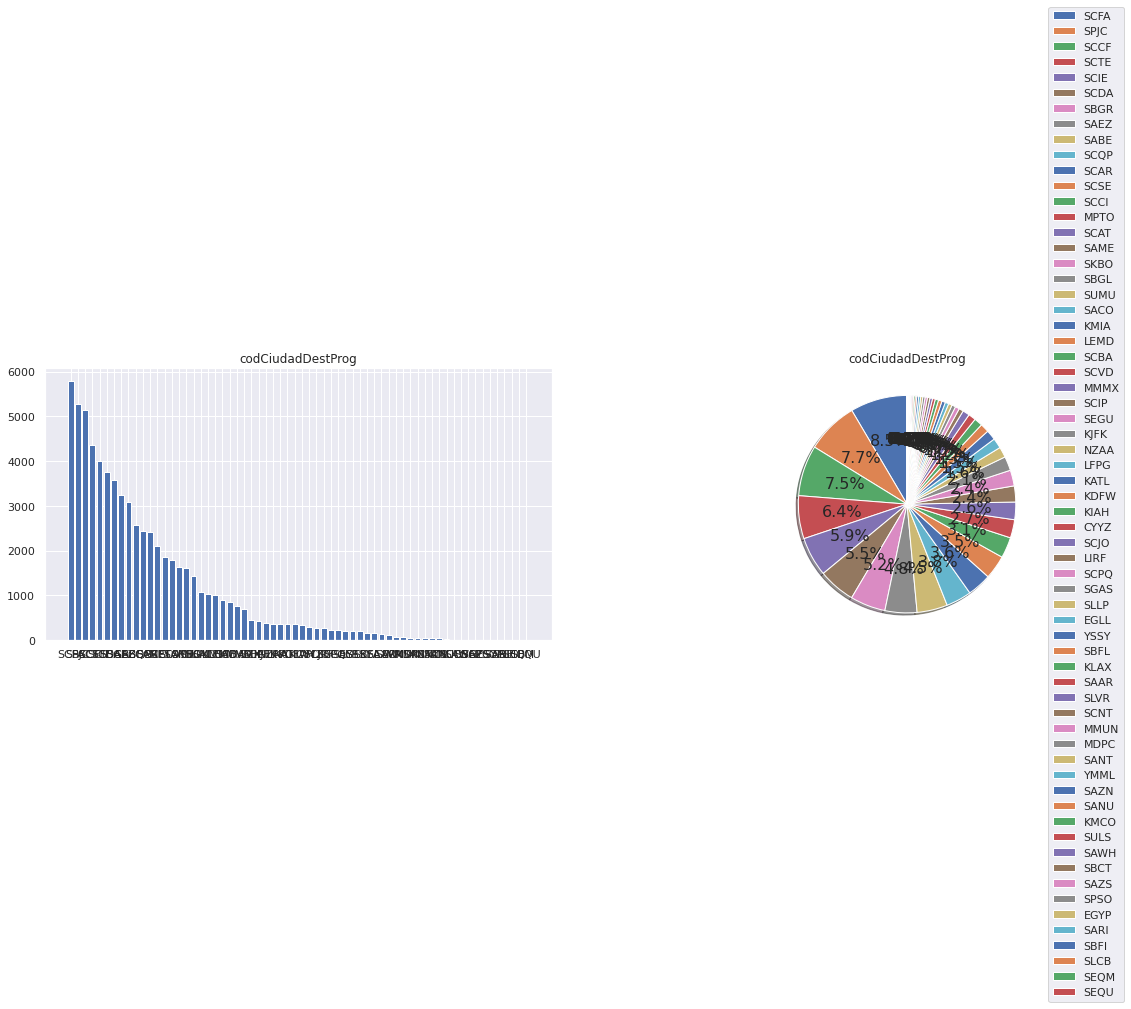

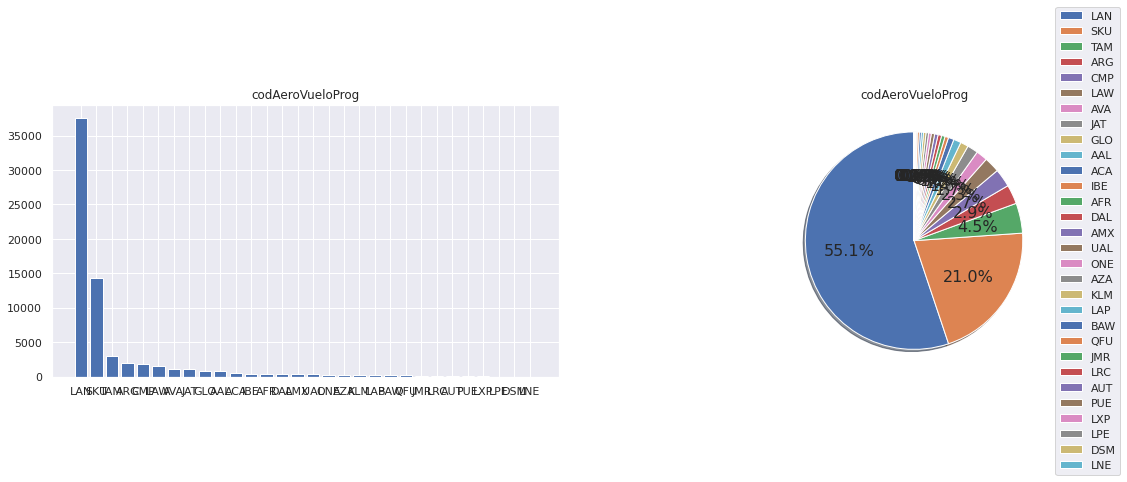

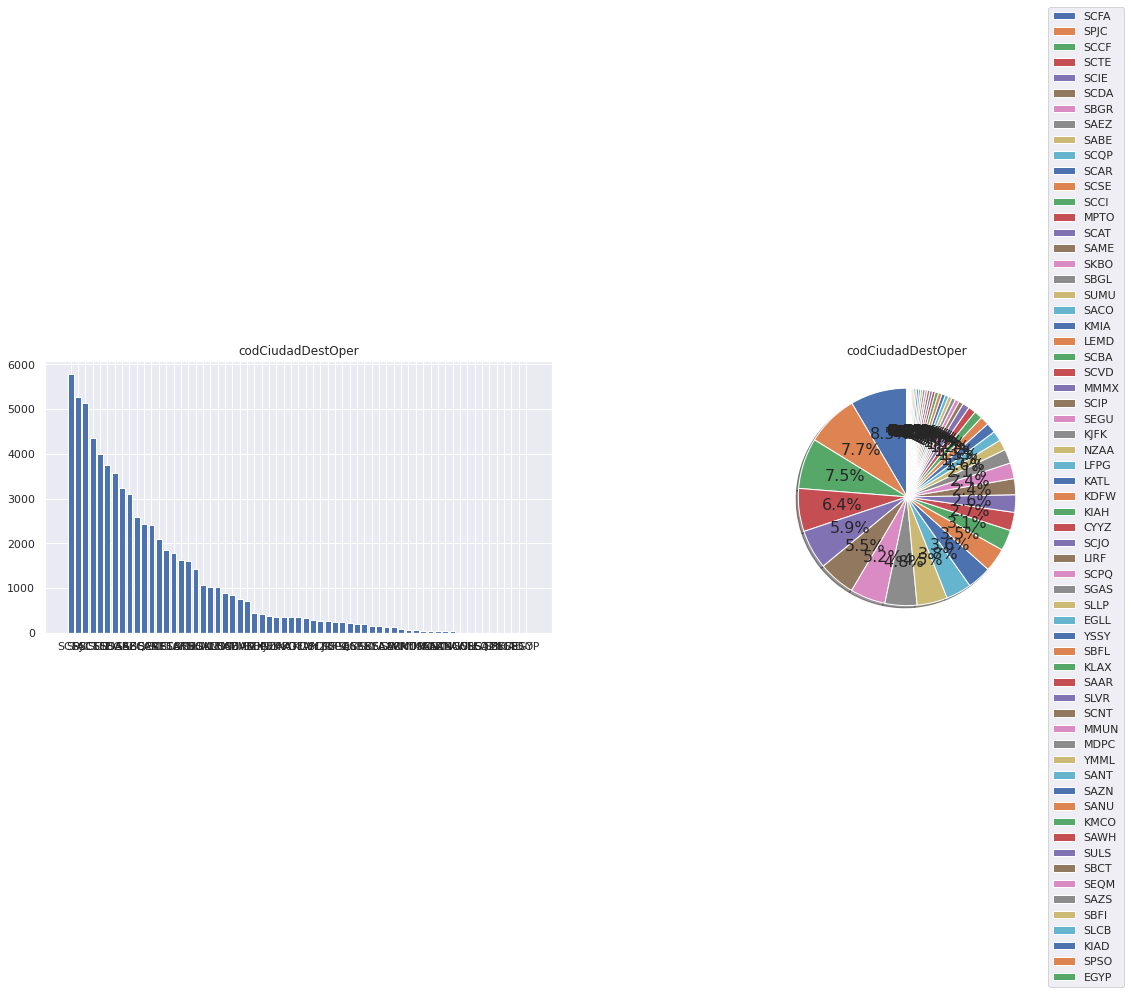

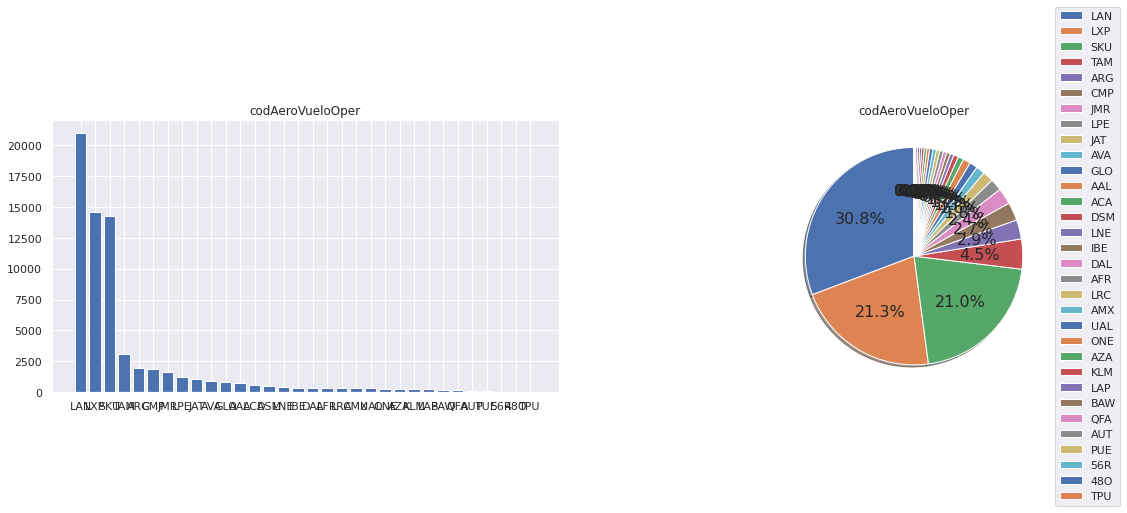

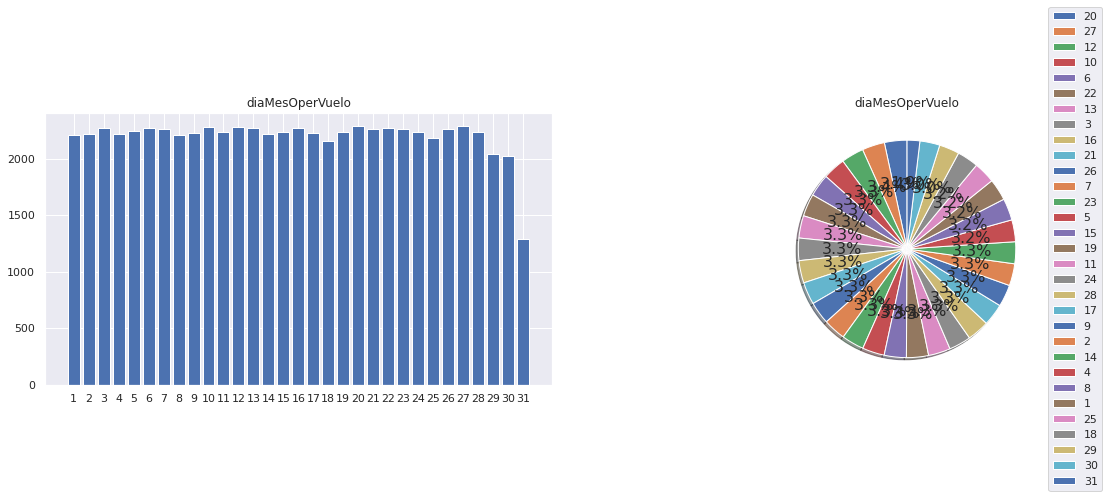

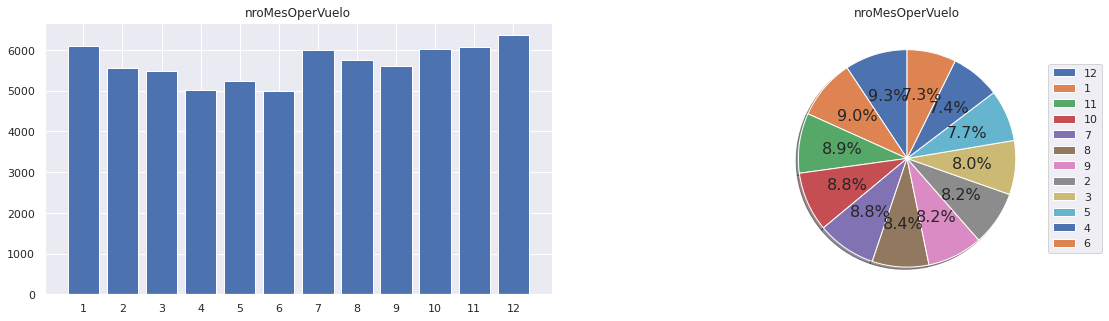

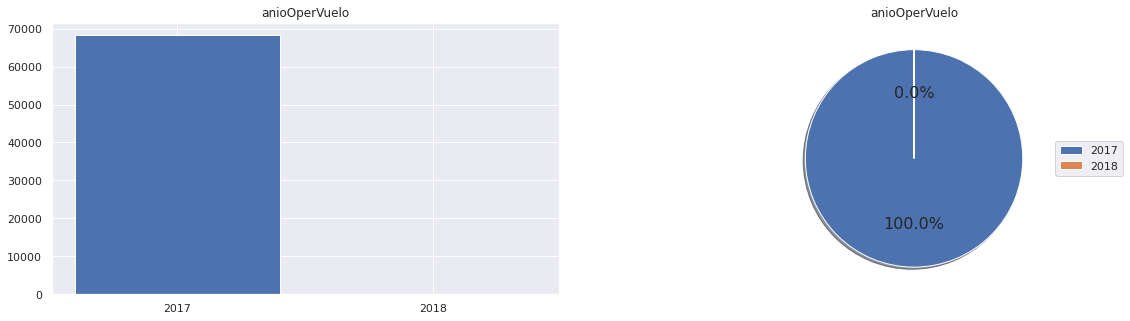

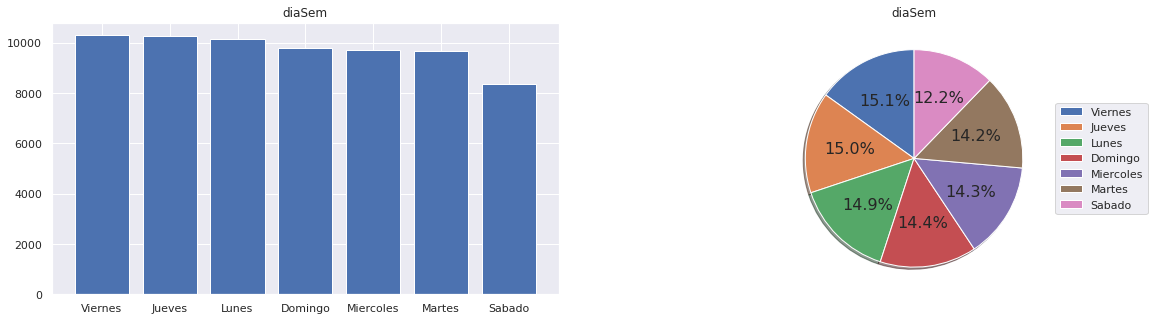

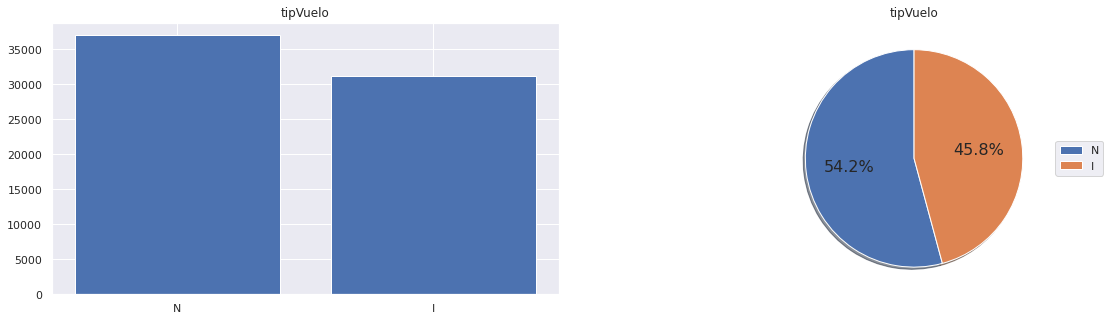

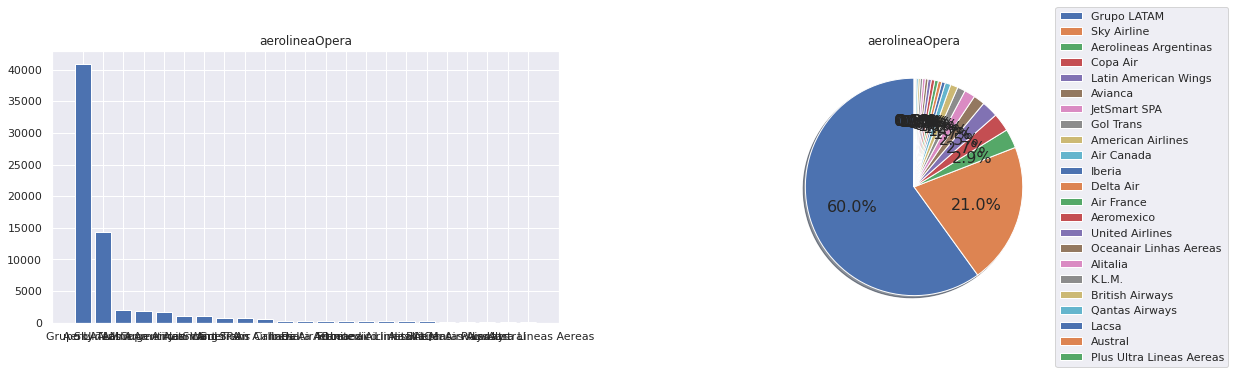

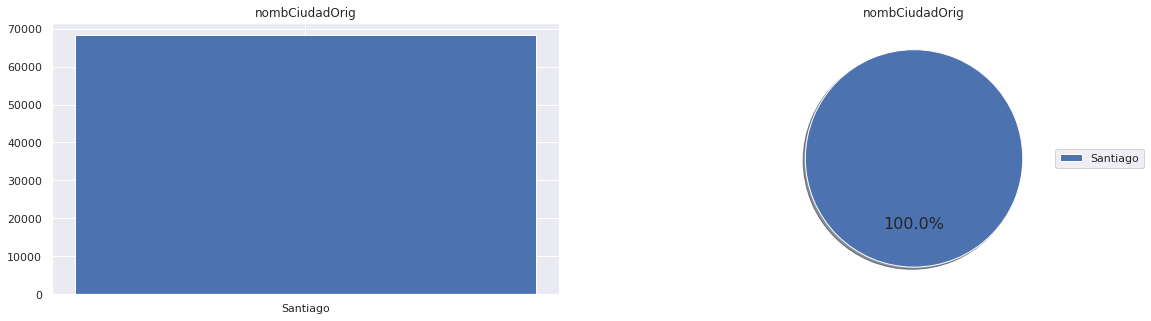

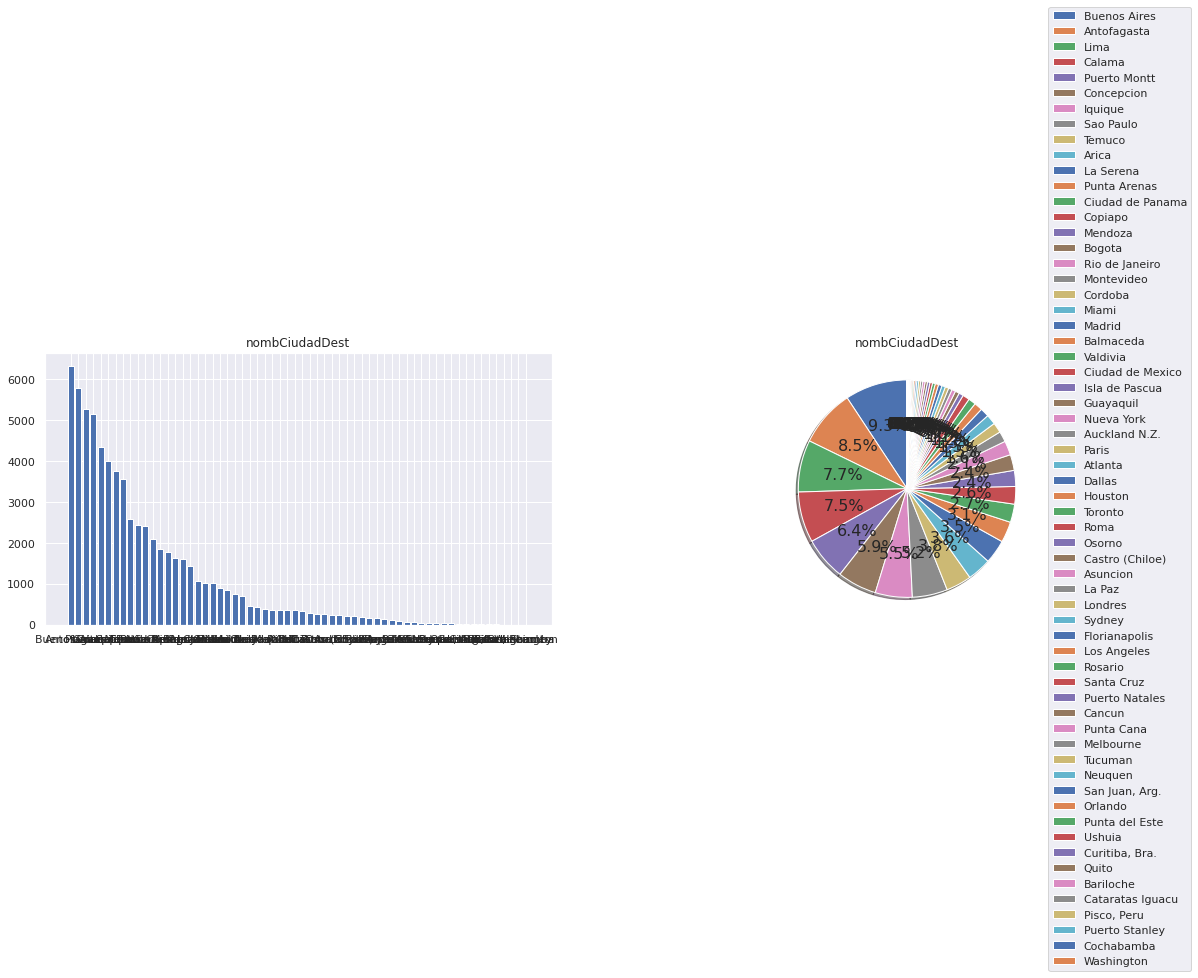

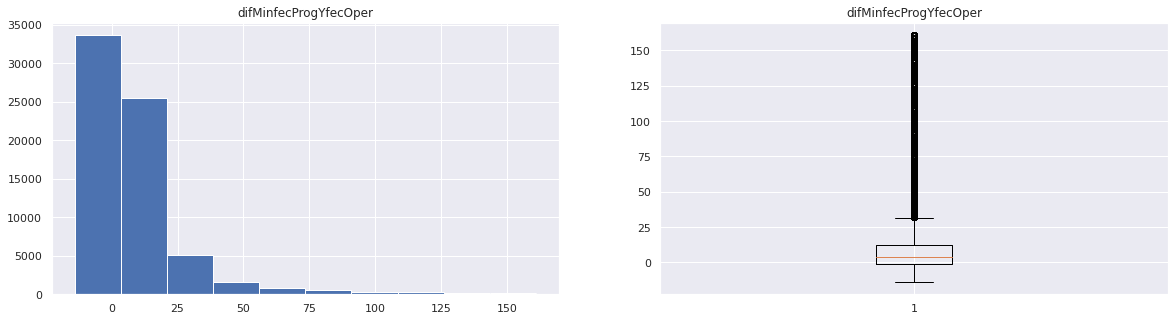

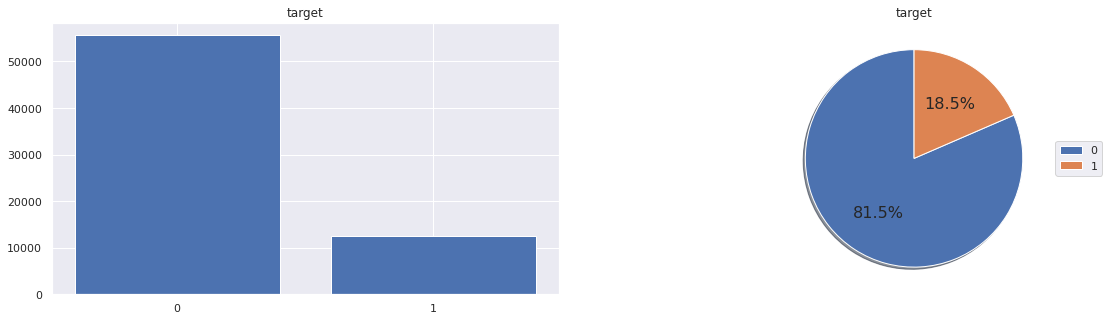

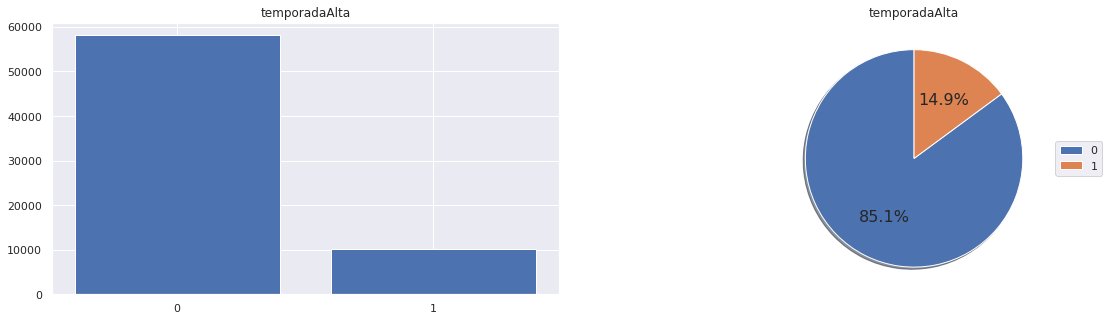

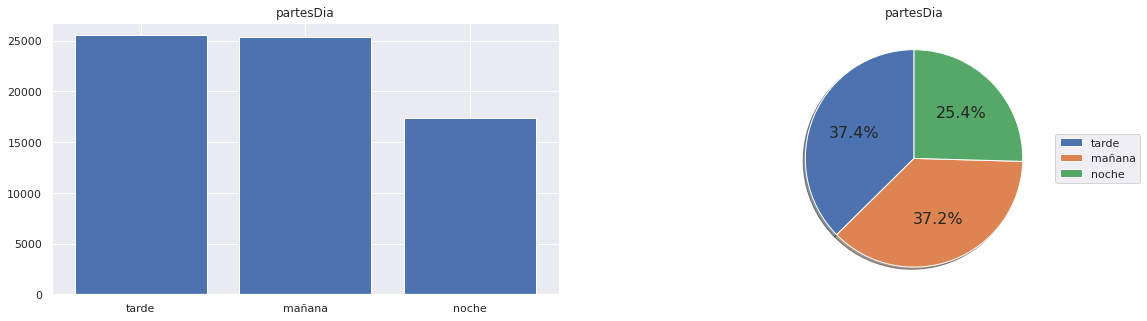

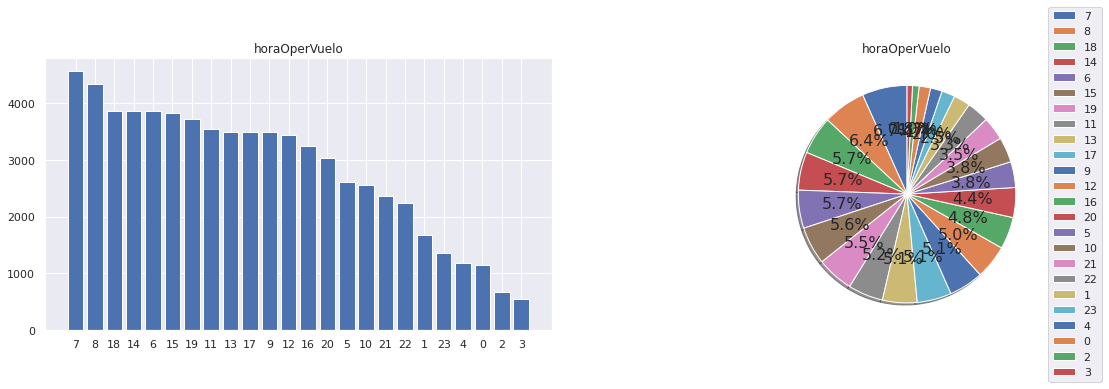

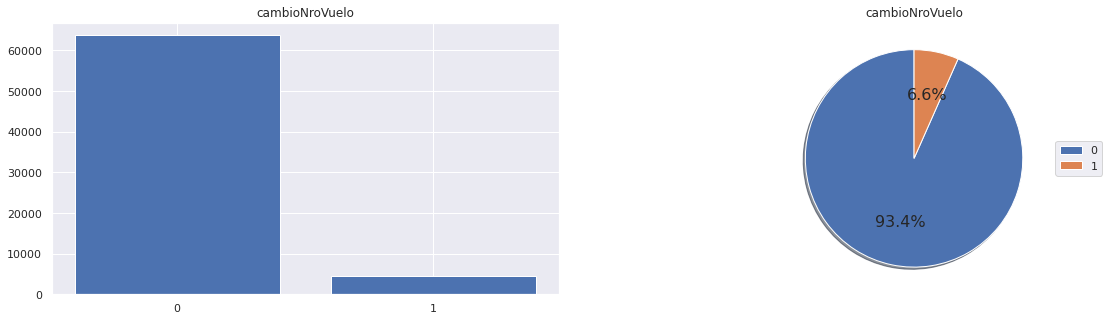

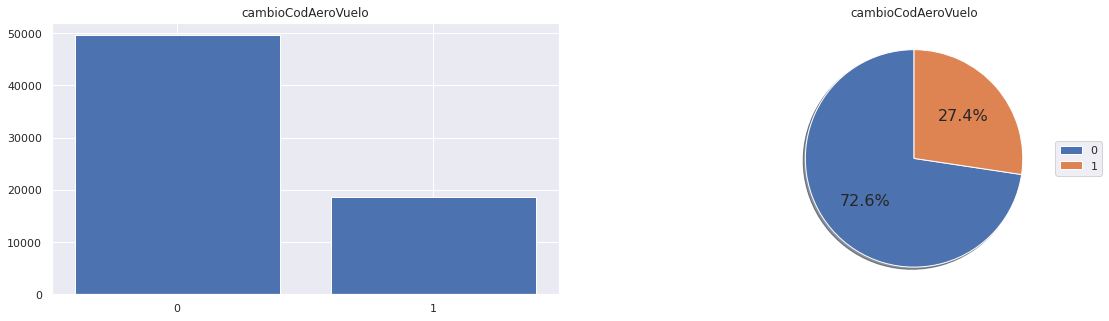

In [45]:
# Análisis Univariado
plot_graph_initial(df_analisis, meta)

### Valores Nulos

In [46]:
fx_porc_missings(df_analisis, only_missings=True)

,n_nulos,%Total


No se observan valores nulos dentro del dataset final

## Analisis Preliminar Bivariado

In [47]:
df_analisis['target']=df_analisis['target'].astype('int64')

In [48]:
df_analisis.head(3)

,fecVueloProg,codCiudadDestProg,codAeroVueloProg,fecVueloOper,codCiudadDestOper,codAeroVueloOper,diaMesOperVuelo,nroMesOperVuelo,anioOperVuelo,diaSem,tipVuelo,aerolineaOpera,nombCiudadOrig,nombCiudadDest,difMinfecProgYfecOper,target,temporadaAlta,partesDia,horaOperVuelo,cambioNroVuelo,cambioCodAeroVuelo
0,2017-01-01 23:30:00,KMIA,AAL,2017-01-01 23:33:00,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,3.0,0,0,noche,23,0,0
1,2017-01-02 23:30:00,KMIA,AAL,2017-01-02 23:39:00,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,9.0,0,0,noche,23,0,0
2,2017-01-03 23:30:00,KMIA,AAL,2017-01-03 23:39:00,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,9.0,0,0,noche,23,0,0


In [49]:
meta

,variable,tipo
1,codCiudadDestProg,category
2,codAeroVueloProg,category
4,codCiudadDestOper,category
5,codAeroVueloOper,category
6,diaMesOperVuelo,category
7,nroMesOperVuelo,category
8,anioOperVuelo,category
9,diaSem,category
10,tipVuelo,category
11,aerolineaOpera,category


codCiudadDestProg


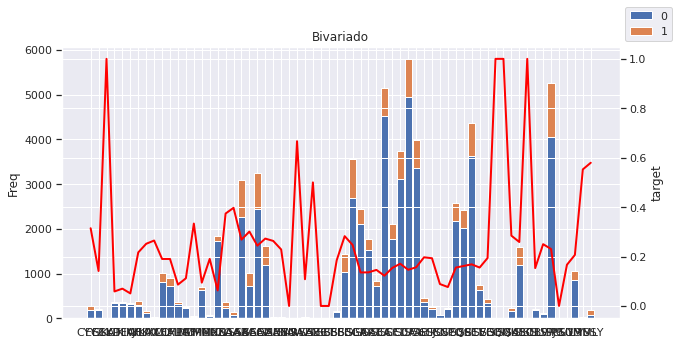

codAeroVueloProg


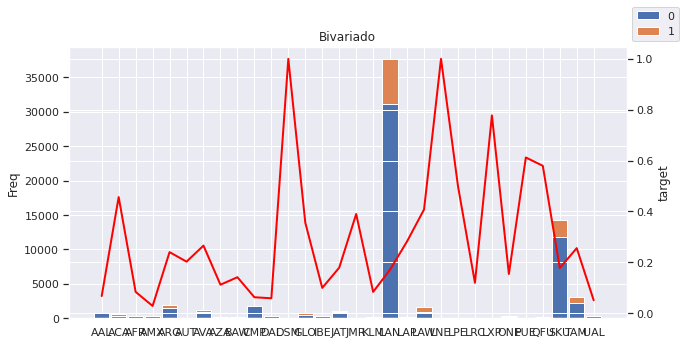

codCiudadDestOper


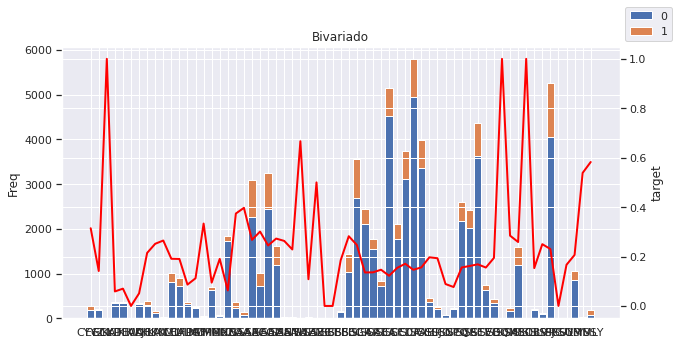

codAeroVueloOper


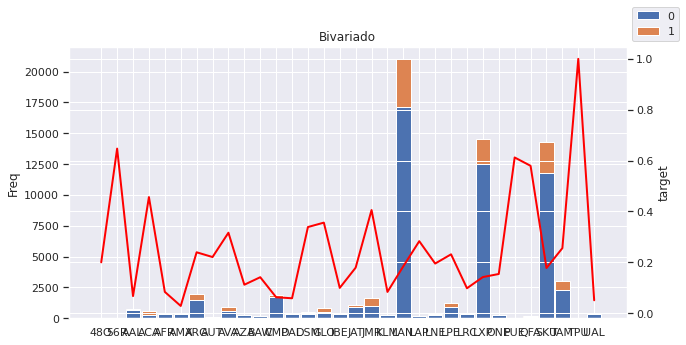

diaMesOperVuelo


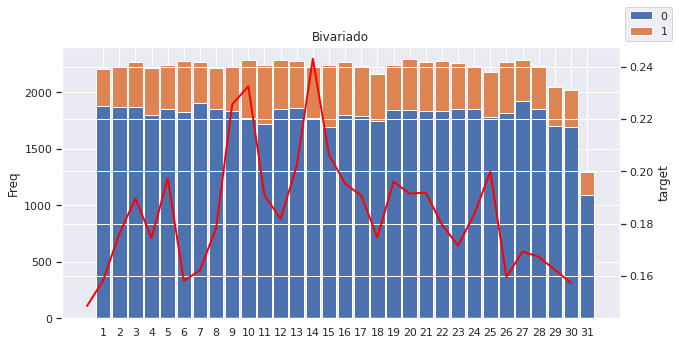

nroMesOperVuelo


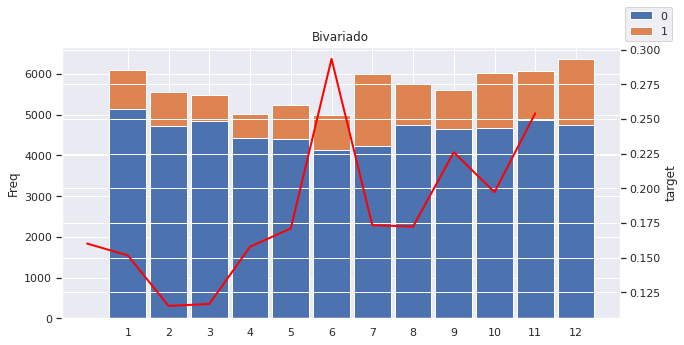

anioOperVuelo


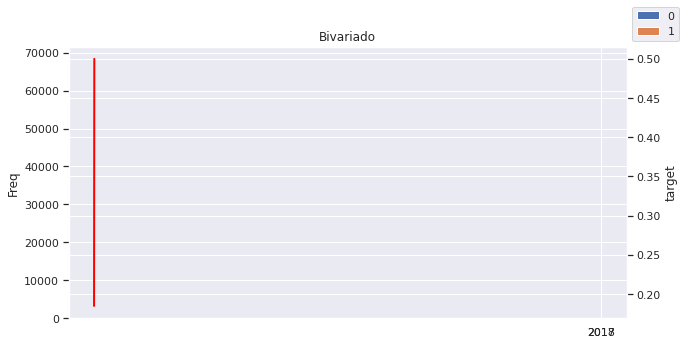

diaSem


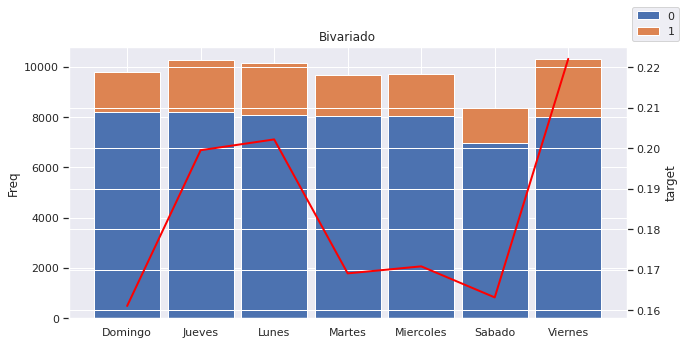

tipVuelo


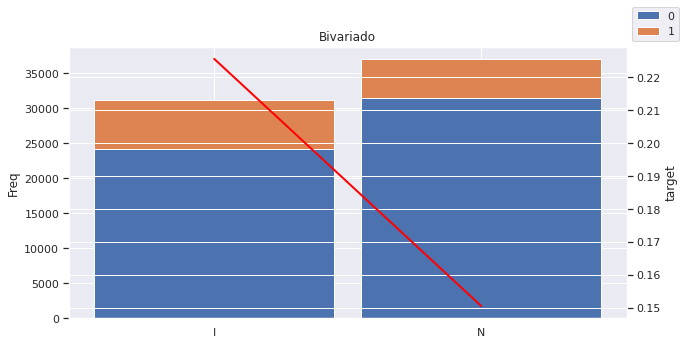

aerolineaOpera


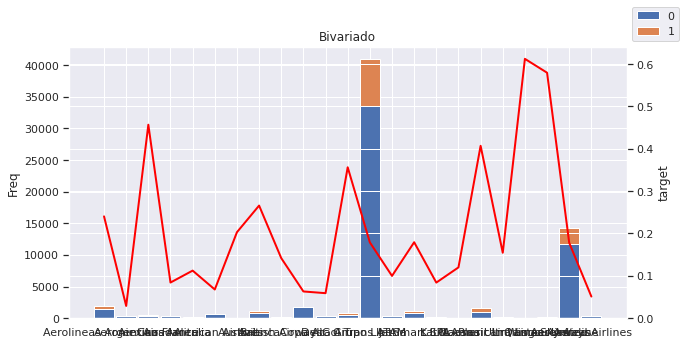

nombCiudadOrig


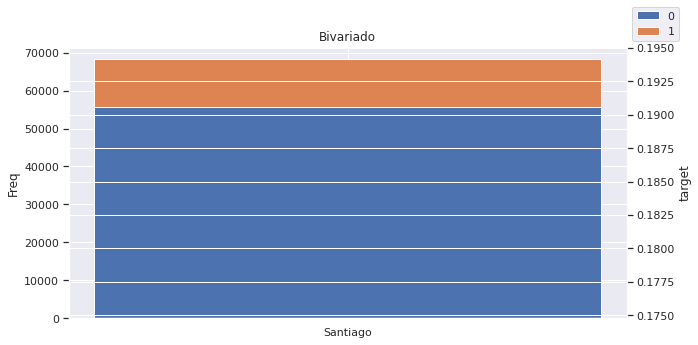

nombCiudadDest


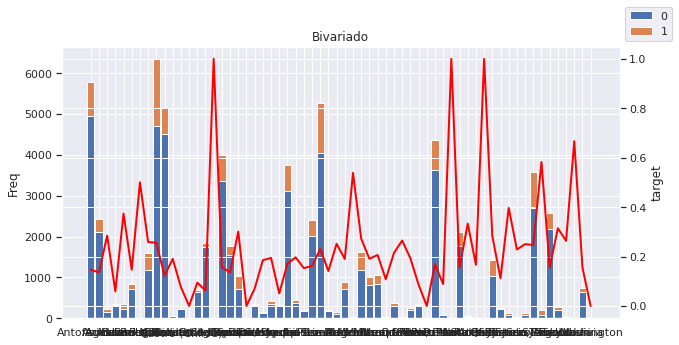

difMinfecProgYfecOper


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of ticklabels (9).

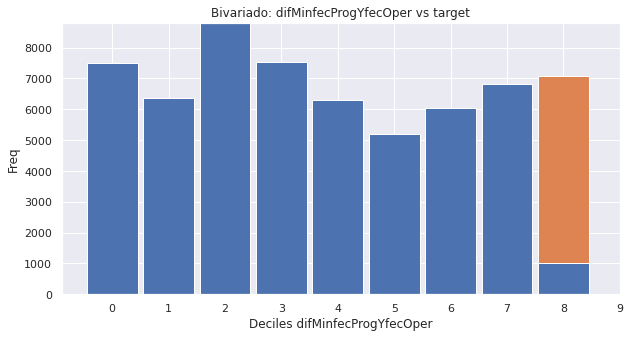

In [50]:
plot_graph_bivariable(df_analisis, meta,'target')

Este análisis nos permite visualizar por tipo categoria de la variable cualitativa y decil de la variable cuantitativa su participación con respecto al target. Esto representa lo que se llama Target Encoding. Nos ayudará en saber como podemos agrupar las variables, así como la representatividad con respecto al target de importancia

## Outliers

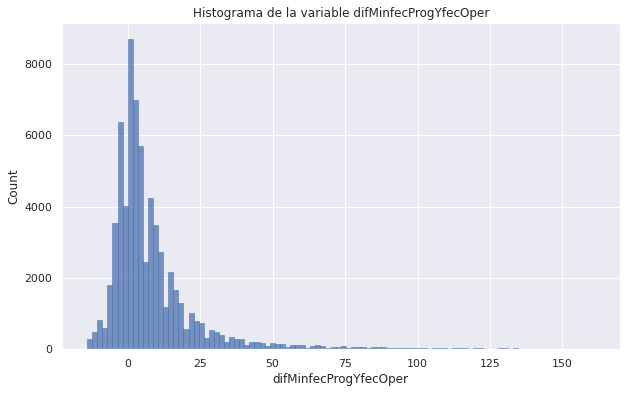

In [51]:
# Analisis mediante un histograma
plt.figure(figsize=(10,6))
sns.histplot(df_analisis['difMinfecProgYfecOper'],
             bins=100,
             edgecolor='b')
plt.title("Histograma de la variable difMinfecProgYfecOper")
plt.show()

Se observa una ligera **asimetria a la derecha (Cola a la derecha)**. Através de este histograma tambien podemos validar la presencia de algunos valores fuera del rango normal de distribución. Veamos un BOXPLOT para analizar estos puntos.

/home/laren.osorio/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


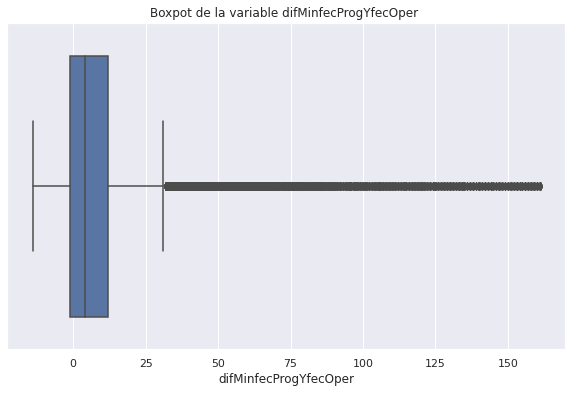

In [52]:
# Analisis mediante un diagrama de cajas (Boxplot)
plt.figure(figsize=(10,6))
sns.boxplot(df_analisis['difMinfecProgYfecOper'])
plt.title("Boxpot de la variable difMinfecProgYfecOper ")
plt.show()

A través del boxplot podemos ver claramente que existen algunos valores a la derecha que pueden no favorecer en el comportamiento habitual de los datos. Veamos un análisis por PERCENTILES

In [53]:
# Análisis de percentiles
for var in feat_numerical:
  print("Variable: ", var)
  fx_percentiles_en_lista(df_analisis[var])

Variable:  difMinfecProgYfecOper


,Percentile,Valor
0,0.0,-14.0
1,0.5,-12.0
2,1.0,-11.0
3,2.5,-8.0
4,5.0,-6.0
5,10.0,-4.0
6,25.0,-1.0
7,50.0,4.0
8,75.0,12.0
9,90.0,26.0


Lo que se busca son **grandes variaciones por percentil**. Por ejemplo para esta variable el percentil **98.5** tiene un valor de 86 sin embargo el percentil 100 tiene un valor 161, casi el doble. es decir solo un **1.5%** concentra valores mayores que 86; se observa una ligera variación de un percentil a otro. Este será nuestro criterio para imputar cada variable.

Se analizaron los percentiles de la variable y se definió en base la punto de corte correspondiente:

In [ ]:
clean_outlier_perc(df_analisis,'difMinfecProgYfecOper', 0.98)

In [ ]:
# Analisis mediante un diagrama de cajas (Boxplot)
plt.figure(figsize=(10,6))
sns.boxplot(df_analisis['difMinfecProgYfecOper'])
plt.title("Boxpot de la variable difMinfecProgYfecOper")
plt.show()

**Registros Repetidos**

In [ ]:
df_analisis.shape

In [ ]:
df_analisis.drop_duplicates(inplace = True)

In [ ]:
df_analisis.shape

## Tratamiento de Variables Categoricas

In [ ]:
dataVuelos = df_analisis.copy()

### Agrupando según ratio de Conversión

In [ ]:
dataVuelos.describe(include='category')

In [ ]:
# Var: codCiudadDestProg
cross_target(dataVuelos,'codCiudadDestProg','target')